In [25]:
from model import DenoisingUNet
from utils import *
from data import mask_dataset
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from glob import glob
import torch.nn as nn
import torch
sampleRate = 49.95

## Train - Val - Test sets

In [26]:
train_path = "train-events"
val_path = "validation-events"
train_files = glob(os.path.join(train_path, '*.npy'))
val_files = glob(os.path.join(val_path, '*.npy'))
print(f"{len(train_files)} train and {len(val_files)} val files.")

18 train and 18 val files.


## Hyperparameters

In [27]:
N_sub = 11
batch_size = 32
hidden_layers = 6
learning_rate = 5e-7
num_epochs = 10

## Datasets and DataLoaders

In [28]:
train_dataset = mask_dataset(data_path='train-events', f_min=1, f_max=10, N_sub=N_sub, sampleRate=sampleRate)
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True)

In [29]:
val_dataset = mask_dataset(data_path='validation-events', f_min=1, f_max=10, N_sub=N_sub, sampleRate=sampleRate)
val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True, shuffle=True)

In [30]:
# GPU
print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device is {device}.')

# model = DenoisingUNet(input_bands=1, output_classes=1, hidden_channels=hidden_layers)
# model.to(device)
# Load model trained at synthetic data
model = DenoisingUNet(input_bands=1, output_classes=1, hidden_channels=hidden_layers)
state = torch.load('./new_model_tests/synthetic-train-2000.pth')
model.load_state_dict(state['model_state_dict'])
model.train()
model.to(device)
# Mean Square Error 
criterion = nn.MSELoss()

# Optimizer:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

NVIDIA GeForce RTX 2070
device is cuda:0.


## Training

In [31]:
epochs_losses_train = []
epochs_losses_val = []
cc_gainz = []
for epoch in range(num_epochs):
    batch_losses = []
    ## TRAIN ##
    for eval_samples, mask in train_loader:
        # to GPU
        mask = mask.to(device)
        eval_samples = eval_samples.to(device)
        # apply mask
        sample = eval_samples * mask.clone().detach()
        sample = torch.unsqueeze(sample.squeeze(), 1)
        # complementary mask
        c_mask = (1-mask).squeeze()

        optimizer.zero_grad()
        # apply complementary mask to output (proj. operator)
        output = model(sample).squeeze()*c_mask
        truth = (eval_samples.squeeze()*c_mask).squeeze()
        loss = criterion(output.squeeze(), truth)
        batch_losses.append(loss.item())
        loss.backward()
        optimizer.step()
    epochs_losses_train.append(np.mean(batch_losses))
    
    model.eval()
    eval_losses = []
    with torch.no_grad():
        for eval_samples, mask in val_loader:
            # to GPU
            mask = mask.to(device)
            eval_samples = eval_samples.to(device)
            # apply mask
            sample = eval_samples * mask.clone().detach()
            sample = torch.unsqueeze(sample.squeeze(), 1)
            # complementary mask
            c_mask = (1-mask).squeeze()

            optimizer.zero_grad()
            # apply complementary mask to output (proj. operator)
            output = model(sample).squeeze()*c_mask
            truth = (eval_samples.squeeze()*c_mask).squeeze()
            loss = criterion(output.squeeze(), truth)
        eval_losses.append(loss.item())
        epochs_losses_val.append(np.mean(eval_losses))
        print(f"Epoch: {epoch} Train Loss: {np.mean(batch_losses)}, Val Loss: {np.mean(eval_losses)}")
    model.train()

Epoch: 0 Train Loss: 0.044849479500618246, Val Loss: 0.047786448150873184
Epoch: 1 Train Loss: 0.04229739809615744, Val Loss: 0.03661663457751274
Epoch: 2 Train Loss: 0.03970054417848587, Val Loss: 0.04159460589289665
Epoch: 3 Train Loss: 0.03697032741788361, Val Loss: 0.039521023631095886
Epoch: 4 Train Loss: 0.034244614210393695, Val Loss: 0.02846563793718815
Epoch: 5 Train Loss: 0.03171422496438026, Val Loss: 0.02021000161767006
Epoch: 6 Train Loss: 0.0294221339498957, Val Loss: 0.03359692171216011
Epoch: 7 Train Loss: 0.027235710883720055, Val Loss: 0.03776104003190994
Epoch: 8 Train Loss: 0.02521843223936028, Val Loss: 0.020959874615073204
Epoch: 9 Train Loss: 0.0233851954071886, Val Loss: 0.02491186000406742


Text(0.5, 1.0, 'Validation MSE')

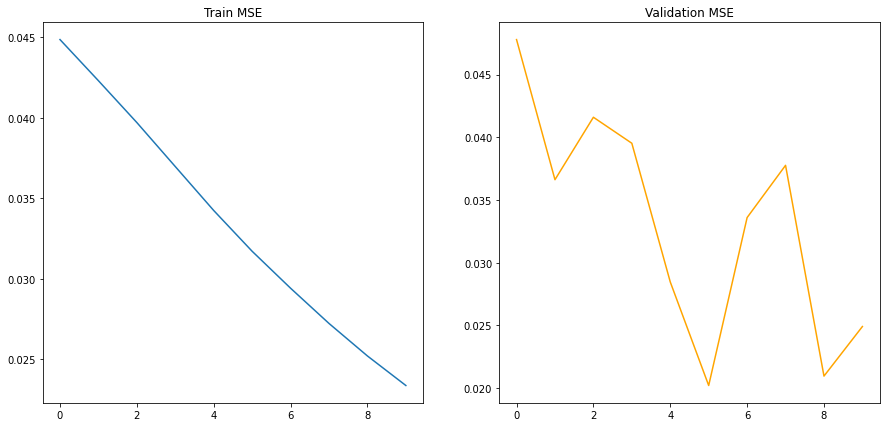

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.plot(epochs_losses_train)
# ax1.set_yscale("log") 
ax1.set_title("Train MSE")
ax2.plot(epochs_losses_val, 'orange')
ax2.set_title("Validation MSE")


In [35]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss
}, "C:\\Users\\nikos\\Desktop\\denoising\\new_model_tests\\yo-more-data-2.pth")
